In [1]:
import pandas as pd
data = pd.read_csv('./simulation_data.csv')

In [2]:
data

,sensor_id,time,value,upper_limit,lower_limit,outlier_status,filtered_value
0,7,2024-10-29 14:39:00.085971,0.124713,0.125659,0.124749,False,0.125316
1,8,2024-10-29 14:39:00.087275,0.230884,0.230253,0.229348,False,0.229726
2,9,2024-10-29 14:39:00.088438,-0.539526,-0.538760,-0.539600,False,-0.539473
3,10,2024-10-29 14:39:00.089619,-0.183105,-0.093742,-0.158516,False,-0.147365
4,11,2024-10-29 14:39:00.090690,-0.671387,-0.689024,-0.794407,False,-0.743844
...,...,...,...,...,...,...,...
643450,11,2024-10-29 18:59:59.845818,-0.854492,-0.729695,-0.812414,False,-0.774498
643451,12,2024-10-29 18:59:59.846883,0.488281,0.500965,0.450836,False,0.466741
643452,13,2024-10-29 18:59:59.847786,0.000000,0.000000,0.000000,False,0.000000
643453,14,2024-10-29 18:59:59.848704,0.000000,0.000000,0.000000,False,0.000000


In [3]:
sensor_7 = data[data['sensor_id']==7]
sensor_7

,sensor_id,time,value,upper_limit,lower_limit,outlier_status,filtered_value
0,7,2024-10-29 14:39:00.085971,0.124713,0.125659,0.124749,False,0.125316
12,7,2024-10-29 14:39:00.337646,0.126807,0.125659,0.124757,False,0.125358
21,7,2024-10-29 14:39:00.590056,0.125909,0.125658,0.124768,False,0.125412
33,7,2024-10-29 14:39:00.842728,0.123816,0.125652,0.124785,False,0.125372
42,7,2024-10-29 14:39:01.094263,0.126208,0.125647,0.124800,False,0.125373
...,...,...,...,...,...,...,...
643404,7,2024-10-29 18:59:58.828492,0.173462,0.174398,0.173663,False,0.173947
643413,7,2024-10-29 18:59:59.082987,0.175555,0.174362,0.173689,False,0.174021
643425,7,2024-10-29 18:59:59.335604,0.172864,0.174362,0.173689,False,0.173948
643434,7,2024-10-29 18:59:59.586002,0.173462,0.174362,0.173690,False,0.173923


---

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


data = sensor_7.copy()
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data['filtered_value'] = scaler.fit_transform(data[['filtered_value']])

# 시계열 데이터로 변환
def create_dataset(df, time_step=1):
    X, y = [], []
    for i in range(len(df) - time_step - 1):
        X.append(df.iloc[i:(i + time_step), 0].values)
        y.append(df.iloc[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 180 ## 약 1분 (데이터 0.3초에 하나씩 들어온다고 가정)
X, y = create_dataset(data[['filtered_value']], time_step)

# 훈련/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# DataLoader로 변환
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# 2. LSTM 모델 구현
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out[:, -1, :])  # 마지막 타임스텝 예측
        return predictions

# 모델 초기화
input_size = 1  # 입력 차원 (filtered_value)
hidden_layer_size = 64
output_size = 1  # 예측할 값은 filtered_value
model = LSTMModel(input_size, hidden_layer_size, output_size)

# 3. 모델 훈련
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 훈련 과정
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch.unsqueeze(-1))  # LSTM은 3D 텐서를 받으므로 차원 확장
        loss = loss_fn(y_pred.squeeze(), y_batch)  # 예측 값과 실제 값 비교
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# 4. 예측
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train.unsqueeze(-1)).squeeze().numpy()
    y_pred_test = model(X_test.unsqueeze(-1)).squeeze().numpy()

Epoch 1/100, Loss: 4.199792238068767e-05
Epoch 2/100, Loss: 3.659449430415407e-05
Epoch 3/100, Loss: 3.5601733543444425e-05
Epoch 4/100, Loss: 3.2311250834027305e-05
Epoch 5/100, Loss: 2.7466156097943895e-05
Epoch 6/100, Loss: 3.840571298496798e-05
Epoch 7/100, Loss: 6.372426287271082e-05
Epoch 8/100, Loss: 5.5422406148863956e-05
Epoch 9/100, Loss: 3.555794319254346e-05
Epoch 10/100, Loss: 2.836726162058767e-05
Epoch 11/100, Loss: 2.719669464568142e-05
Epoch 12/100, Loss: 2.7394920834922232e-05
Epoch 13/100, Loss: 2.7228545150137506e-05
Epoch 14/100, Loss: 2.7215490263188258e-05
Epoch 15/100, Loss: 2.739464252954349e-05
Epoch 16/100, Loss: 2.7803933335235342e-05
Epoch 17/100, Loss: 2.8518972612801008e-05
Epoch 18/100, Loss: 2.955650597868953e-05
Epoch 19/100, Loss: 3.0884264560882e-05
Epoch 20/100, Loss: 3.23849635606166e-05
Epoch 21/100, Loss: 3.383447619853541e-05
Epoch 22/100, Loss: 3.5066299460595474e-05
Epoch 23/100, Loss: 3.602260767365806e-05
Epoch 24/100, Loss: 3.67329121218062

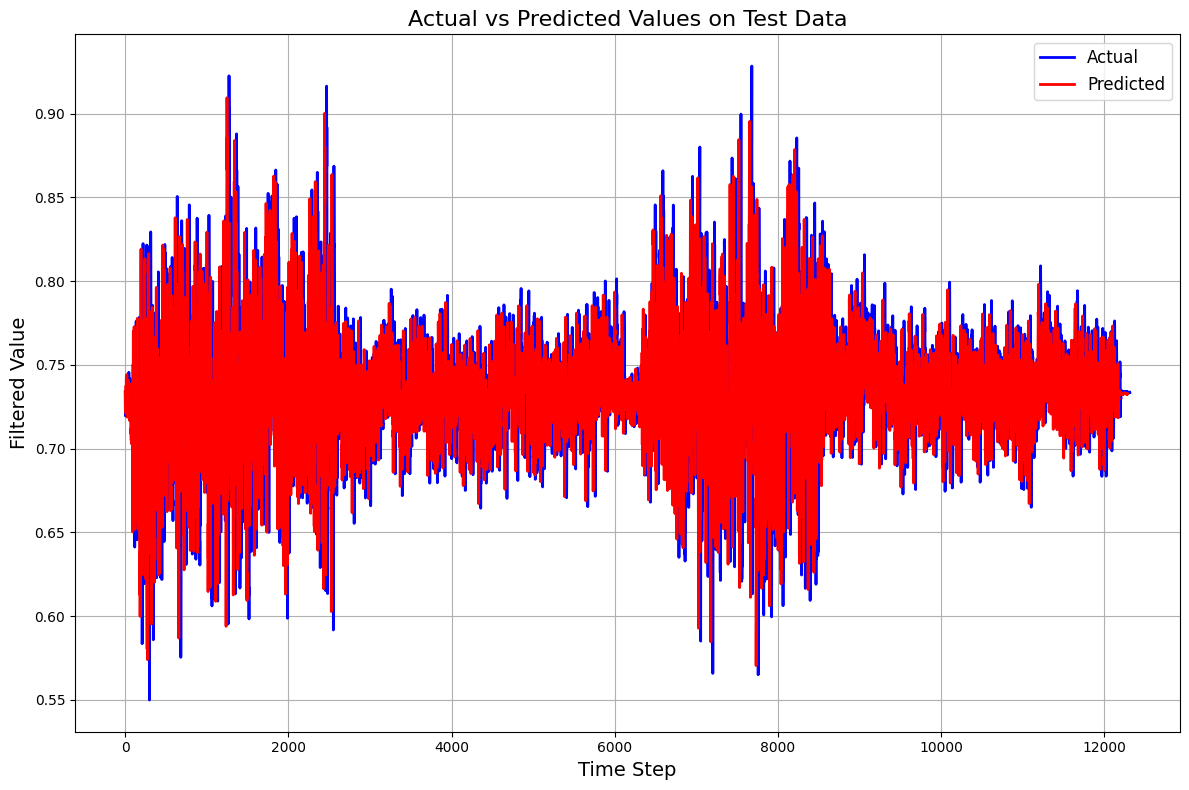

In [22]:
# 시각화
plt.figure(figsize=(12, 8))  # 그래프 크기 설정
plt.plot(range(len(y_test)), y_test, label='Actual', color='blue', linewidth=2)
plt.plot(range(len(y_pred_test)), y_pred_test, label='Predicted', color='red',linewidth=2)
plt.xlabel('Time Step', fontsize=14)  # x축 레이블
plt.ylabel('Filtered Value', fontsize=14)  # y축 레이블
plt.title('Actual vs Predicted Values on Test Data', fontsize=16)
plt.legend(fontsize=12)  # 범례 크기
plt.grid(True)  # 그리드 추가
plt.tight_layout()  # 레이아웃 조정
plt.show()

예측값& 실제값 데이터 시각화 따로 진행

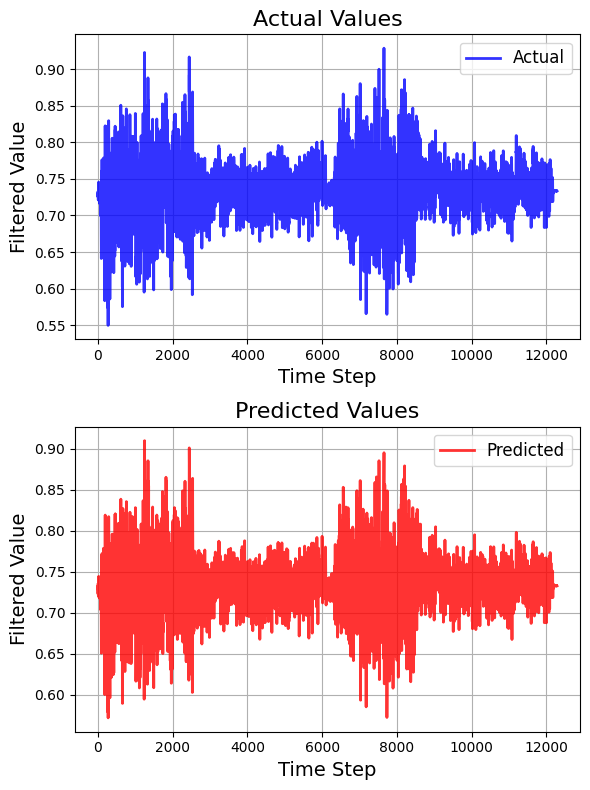

In [19]:
import matplotlib.pyplot as plt

# 두 개의 서브플롯 설정 (2행 1열)
plt.figure(figsize=(6, 8))

# 실제값 그래프
plt.subplot(2, 1, 1)  # 2행 1열 중 첫 번째
plt.plot(range(len(y_test)), y_test.numpy(), label='Actual', color='blue', alpha = 0.8, linewidth=2)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Filtered Value', fontsize=14)
plt.title('Actual Values', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# 예측값 그래프
plt.subplot(2, 1, 2)  # 2행 1열 중 두 번째
plt.plot(range(len(y_pred_test)), y_pred_test, label='Predicted', color='red', alpha = 0.8, linewidth=2)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Filtered Value', fontsize=14)
plt.title('Predicted Values', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# 레이아웃 조정
plt.tight_layout()
plt.show()


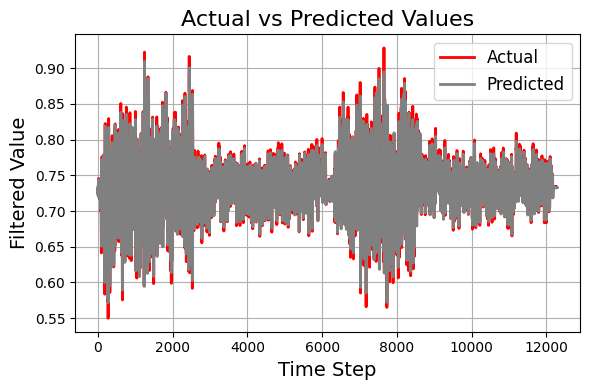

In [33]:
# 시각화
plt.figure(figsize=(6, 4))  # 그래프 크기 설정
plt.plot(range(len(y_test)), y_test.numpy(), label='Actual', color='red', linewidth=2)
plt.plot(range(len(y_pred_test)), y_pred_test, label='Predicted', color='grey', linewidth=2)
plt.xlabel('Time Step', fontsize=14)  # x축 레이블
plt.ylabel('Filtered Value', fontsize=14)  # y축 레이블
plt.title('Actual vs Predicted Values', fontsize=16)  # 제목
plt.legend(fontsize=12)  # 범례 크기
plt.grid(True)  # 그리드 추가
plt.tight_layout()  # 레이아웃 조정
plt.show()


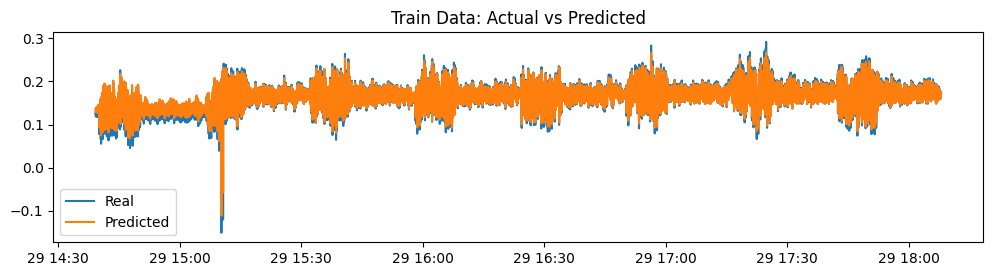

In [20]:
# 실제 값과 예측 값 시각화
plt.figure(figsize=(12, 6))

# 훈련 데이터 예측 결과
plt.subplot(2, 1, 1)
plt.plot(data.index[time_step:len(X_train) + time_step], scaler.inverse_transform(y_train.unsqueeze(1).numpy()), label='Real')
plt.plot(data.index[time_step:len(X_train) + time_step], scaler.inverse_transform(y_pred_train.reshape(-1, 1)), label='Predicted')
plt.title('Train Data: Actual vs Predicted')
plt.legend()